<h1>Table of content<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Data-preparation" data-toc-modified-id="Data-preparation-1">Data preparation</a></span><ul class="toc-item"><li><span><a href="#Intermediate-conclusion" data-toc-modified-id="Intermediate-conclusion-1.1">Intermediate conclusion</a></span></li></ul></li><li><span><a href="#Data-analysis" data-toc-modified-id="Data-analysis-2">Data analysis</a></span><ul class="toc-item"><li><span><a href="#Intermediate-conclusion" data-toc-modified-id="Intermediate-conclusion-2.1">Intermediate conclusion</a></span></li></ul></li><li><span><a href="#Model" data-toc-modified-id="Model-3">Model</a></span><ul class="toc-item"><li><span><a href="#The-final-stage" data-toc-modified-id="The-final-stage-3.1">The final stage</a></span></li><li><span><a href="#Conclusion" data-toc-modified-id="Conclusion-3.2">Conclusion</a></span></li></ul></li></ul></div>

# Recovery of gold from ore

Preparing a prototype of a machine learning model for a company that develops solutions for the efficient operation of industrial enterprises is necessary.

The model should predict the recovery factor for gold from gold ore.

The model will help optimize production to launch an enterprise with profitable characteristics.

Necessary:

1. Prepare data;
2. Conduct exploratory data analysis;
3. Build and train the model.



## Data preparation

In [1]:
import pandas as pd
import numpy as np
import datetime
import pandas_profiling
from pandas_profiling import ProfileReport

from sklearn.metrics import mean_absolute_error, make_scorer
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.dummy import DummyRegressor

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import warnings
warnings.filterwarnings('ignore')
sns.set(rc={'figure.figsize':(12,7)})

<div style='border-radius: 15px; box-shadow: 2px 2px 2px; border: 1px solid green; padding: 20px'>

Based on the project description, each dataset has a unique column with <code>date</code>. It must be a column with no gaps and a unique value. On it, we will index all our data. Immediately after reading the files, we will put down all the indices. The condition says that parameters adjacent in time are often similar; this will be useful to us when filling in the gaps.
</div>

In [2]:
# Import data
df_train = pd.read_csv('gold_recovery_train_new.csv')
df_test = pd.read_csv('gold_recovery_test_new.csv')
df_full = pd.read_csv('gold_recovery_full_new.csv')
# For looping
all_df = [df_train,df_test,df_full]
# Indexes
for df in all_df:
    df.set_index('date',inplace=True)
    print(df.shape)

(14149, 86)
(5290, 52)
(19439, 86)


<div style='border-radius: 15px; box-shadow: 2px 2px 2px; border: 1px solid green; padding: 20px'>

The tables have too much data, so let's examine them using the <code>pandas_profiling</code> library.
    
In order not to heavily overload the calculations, we specify the following parameters: <code>(explorative = False, minimal = True)</code>
    
</div>

In [3]:
df_train_profile = df_train.profile_report(explorative = False, minimal = True)
df_test_profile = df_test.profile_report(explorative = False, minimal = True)
df_full_profile = df_full.profile_report(explorative = False, minimal = True)

In [4]:
df_full_profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

<div style='border-radius: 15px; box-shadow: 2px 2px 2px border: 1px solid green; padding: 20px'>
    
Three files were provided with the parameters for converting a mixture of gold ore into the final concentrate, which was measured every hour at. The technological process is quite complex. Therefore, various features got into the data, but stages and types of parameters can combine all of them.

<b>Types of Stages:</b>
- <code>rougher</code> — flotation;
- <code>primary_cleaner</code> - primary cleaning;
- <code>secondary_cleaner</code> - secondary cleaning;
- <code>final</code> — final characteristics.

<b>Parameter Types:</b>
- <code>input</code> — raw material parameters;
- <code>output</code> — product parameters;
- <code>state</code> — parameters characterizing the current state of the stage;
- <code>calculation</code> — calculated characteristics.
    
Each step and type of parameter has corresponding measurements of different parameters. This may be the concentration of the substance, the grain size, the number of tailings, etc.
<hr>
<b>3 files are: </b>
    
- General sample - contains all the data;
- Training sample - is a slice (75%) of the total sample;
- Test sample - is a slice (25%) of the total sample, except target features and 32 more parameters that, for some reason, were not included in it.
    <hr>
<b>Let's describe the general sample, consisting of the training and test samples.</b>
- 86 columns and 19439 lines;
- Each column displays the parameter value with different parameter types and step types;
- There are 4481 missing values in the sample, which is only 0.3%;
- As it was said in the condition - the time parameter is a unique value, so we took it as an index and a unique identifier;
- All other parameters are numerical;
- The data contains zero values of the final metal concentrate (2%) and the absolute waste tailings (4.4%). We won't process these null values and replace them with something because some mixtures can contain null values;
- Skewed histogram of calculated flotation characteristics <code>sulfate_to_au_concentrate</code>, <code>floatbank10_sulfate_to_au_feed</code>,<code>floatbank11_sulfate_to_au_feed</code>. This was due to the large spread of values around the mean. Because of this, the graph does not look like a monotonous one. We need to find out what these characteristics are responsible for. These parameters are not in the test set, so you don't have to process them. Most likely, they have little effect on the final cleaning efficiency;
- Most histograms of features have the form of a normal distribution. Some of them have a tail in the zero part of the abscissa.

    
</div>

In [5]:
df_names = ['Train', 'Test', 'Original sample'] 

def find_null(df_list):
    for df,name in zip(df_list,df_names):
        i_list=[]
        isna_table = pd.DataFrame(df.isna().mean().round(4)*100).sort_values(by=0)[::-1]

        for i in range(len(isna_table)):
            if isna_table[0][i]  > 0:
                i_list.append(i)
        null_table = pd.DataFrame(isna_table[0][i_list])
        if null_table.sum().sum() == 0:
            print(f'In {name} all gaps are filled')
        else:
            print('Percentage of passes in', name)
            display(null_table.style.background_gradient('magma'))
    
find_null(all_df)

Percentage of passes in Train


Percentage of passes in Test


Percentage of passes in Original sample


<div style='border-radius: 15px; box-shadow: 2px 2px 2px; border: 1px solid green; padding: 20px'>

As we can see, there are not so many gaps in the tables, especially in the Test set.
    
Given that the data is marked by time and recorded with an interval of only 1 hour, it is possible to replace the missing values with their neighbors.
    
</div>

<div style='border-radius: 15px; box-shadow: 2px 2px 2px; border: 1px solid green; padding: 20px'>
    
Let's check that the recovery efficiency is calculated correctly. Calculate it on the training sample for the feature <code>rougher.output.recovery</code>. Let's find the MAE between our calculations and the feature value. Let's describe the conclusions.
    
The formula calculates recovery efficiency.

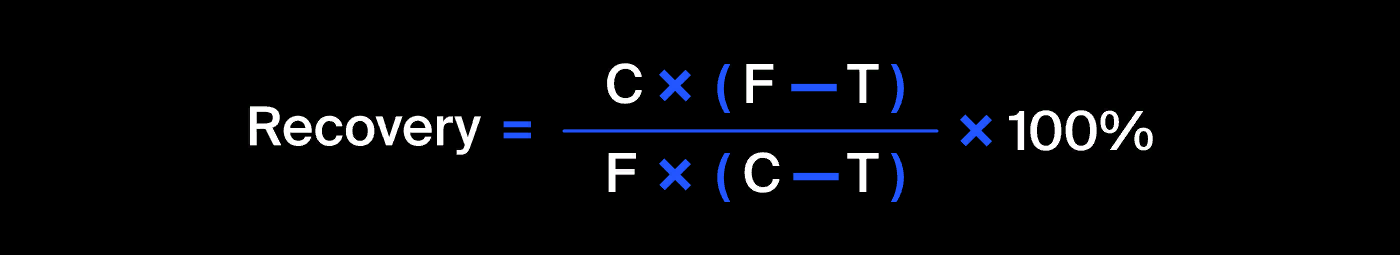

Where:
    
- C is the proportion of gold in the concentrate after flotation/refining;
- F is the proportion of gold in the raw material/concentrate before flotation/refining;
- T is the proportion of gold in tailings after flotation/cleaning.
</div>

In [6]:
# Values in the training set
recovery_original = df_train['rougher.output.recovery']

In [7]:
# Share of gold in concentrate after flotation/refining
C = df_train['rougher.output.concentrate_au']
# Share of gold in raw material/concentrate before flotation/refining
F = df_train['rougher.input.feed_au']
# Proportion of gold in waste tailings after flotation/cleaning
T = df_train['rougher.output.tail_au']
# Recovery efficiency
recovery = 100* (C*(F-T)) / (F*(C-T))
# MAE
MAE = mean_absolute_error(recovery_original, recovery)
# Derive the values
print(f'MAE: {MAE}')
print(f'Gaps in calculation: {recovery.isna().sum()}')
print(f'Gaps in {df_names[0]}: {recovery_original.isna().sum()}')


MAE: 1.1131451184435918e-14
Gaps in calculation: 0
Gaps in Train: 0


<div style='border-radius: 15px; box-shadow: 2px 2px 2px; border: 1px solid green; padding: 20px'>
Our calculated recovery efficiency values match the actual values for the training set. This means that everything is in order with the data, and there are no random values ​​in the table.
    
Let's analyze the features that are not available in the test sample.
    
</div>

In [8]:
missing = list(set(df_train.columns) - set(df_test.columns))
missing.sort()
display(missing)

['final.output.concentrate_ag',
 'final.output.concentrate_au',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.recovery',
 'final.output.tail_ag',
 'final.output.tail_au',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_au',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'rougher.calculation.au_pb_ratio',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_au',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.recovery',
 'rougher.output.tail_ag',
 'rougher.output.tail_au',
 'rougher.output.ta

<div style='border-radius: 15px; box-shadow: 2px 2px 2px; border: 1px solid green; padding: 20px'>

<b>There are no obvious columns in the test set: </b>
- <code>rougher.output.recovery</code> rough concentrate recovery efficiency;
- <code>final.output.recovery</code> final concentrate recovery efficiency.
   
<b>According to the task, we must predict these signs.</b>
      
<hr>
Test sample from non-obvious columns: we do not have information on the parameters of the products of the entire technological process and the calculated fluctuation characteristics of the following parameters:
    
- concentrate and waste tailings of sodium sulfide, gold, silver, and lead;
- sulfate-to-gold flotation plant;
- sulfate content in gold;
- the ratio of gold to lead.
    
<b>There are 32 missing columns in total.</b>
<hr>
<b>The total number of columns inaccessible in the test sample is 34.</b>
    
These columns will be removed from the training set when training our model.
    
</div>

<div style='border-radius: 15px; box-shadow: 2px 2px 2px; border: 1px solid green; padding: 20px'>

The data is ordered in time. And if at time t we have a gap, the value closest to the correct value is either at time t-1 or t+1. Fill in the gaps in the training data with the nearest value over time t+1. Let's do interpolation
    
</div>

In [9]:
df_full = df_full.fillna(method='ffill')
df_train = df_train.fillna(method='ffill')
df_test = df_test.fillna(method='ffill')
all_df = [df_train,df_test,df_full]

find_null(all_df)

In Train all gaps are filled
In Test all gaps are filled
In Original sample all gaps are filled


<div style='border-radius: 15px; box-shadow: 2px 2px 2px; border: 1px solid green; padding: 20px'>
    
### Intermediate conclusion
    
Three files were provided with the parameters for converting a mixture of gold ore into the final concentrate, which was measured every hour at. The technological process is quite complex. Therefore, various features got into the data, but stages and types of parameters can combine all of them.
    
<b>Types of Stages:</b>
- <code>rougher</code> — flotation;
- <code>primary_cleaner</code> - primary cleaning;
- <code>secondary_cleaner</code> - secondary cleaning;
- <code>final</code> — final characteristics.

<b>Parameter Types:</b>
- <code>input</code> — raw material parameters;
- <code>output</code> — product parameters;
- <code>state</code> — parameters characterizing the current state of the stage;
- <code>calculation</code> — calculated characteristics.
    
Each step and type of parameter has corresponding measurements of different parameters. This may be the concentration of the substance, the grain size, the number of tailings, etc.
<hr>
Three files are:
    
- General sample - contains all the data;
- Training sample - is a slice (75%) of the total sample;
- Test sample - is a slice (25%) of the total sample, except target features and 32 more parameters that, for some reason, were not included in it.
    <hr>
 
We have done some data preprocessing.
- Fill in the gaps with values adjacent to them since the data is ordered in time. And if at time t we have a gap, the value closest to the correct value is either at time t-1 or t+1. Fill in the gaps in the training data with the nearest value over time t+1;
- Our calculated recovery efficiency values match the actual values for the training set. This means that everything is in order with the data, and there are no random values ​​in the table.

<hr>
    
The next step is to analyze the data:

- Track the change in the concentration of metals at various stages of purification;
- Compare the sizes of granules on different samples;
- To study the total concentration of all elements at various stages of purification.
    
After analyzing the data, we will be able to select the necessary parameters for training and testing the model.

</div>  

## Data analysis

<div style='border-radius: 15px; box-shadow: 2px 2px 2px; border: 1px solid green; padding: 20px'>

How does the concentration of metals (Au, Ag, Pb) change at different stages of purification.
    
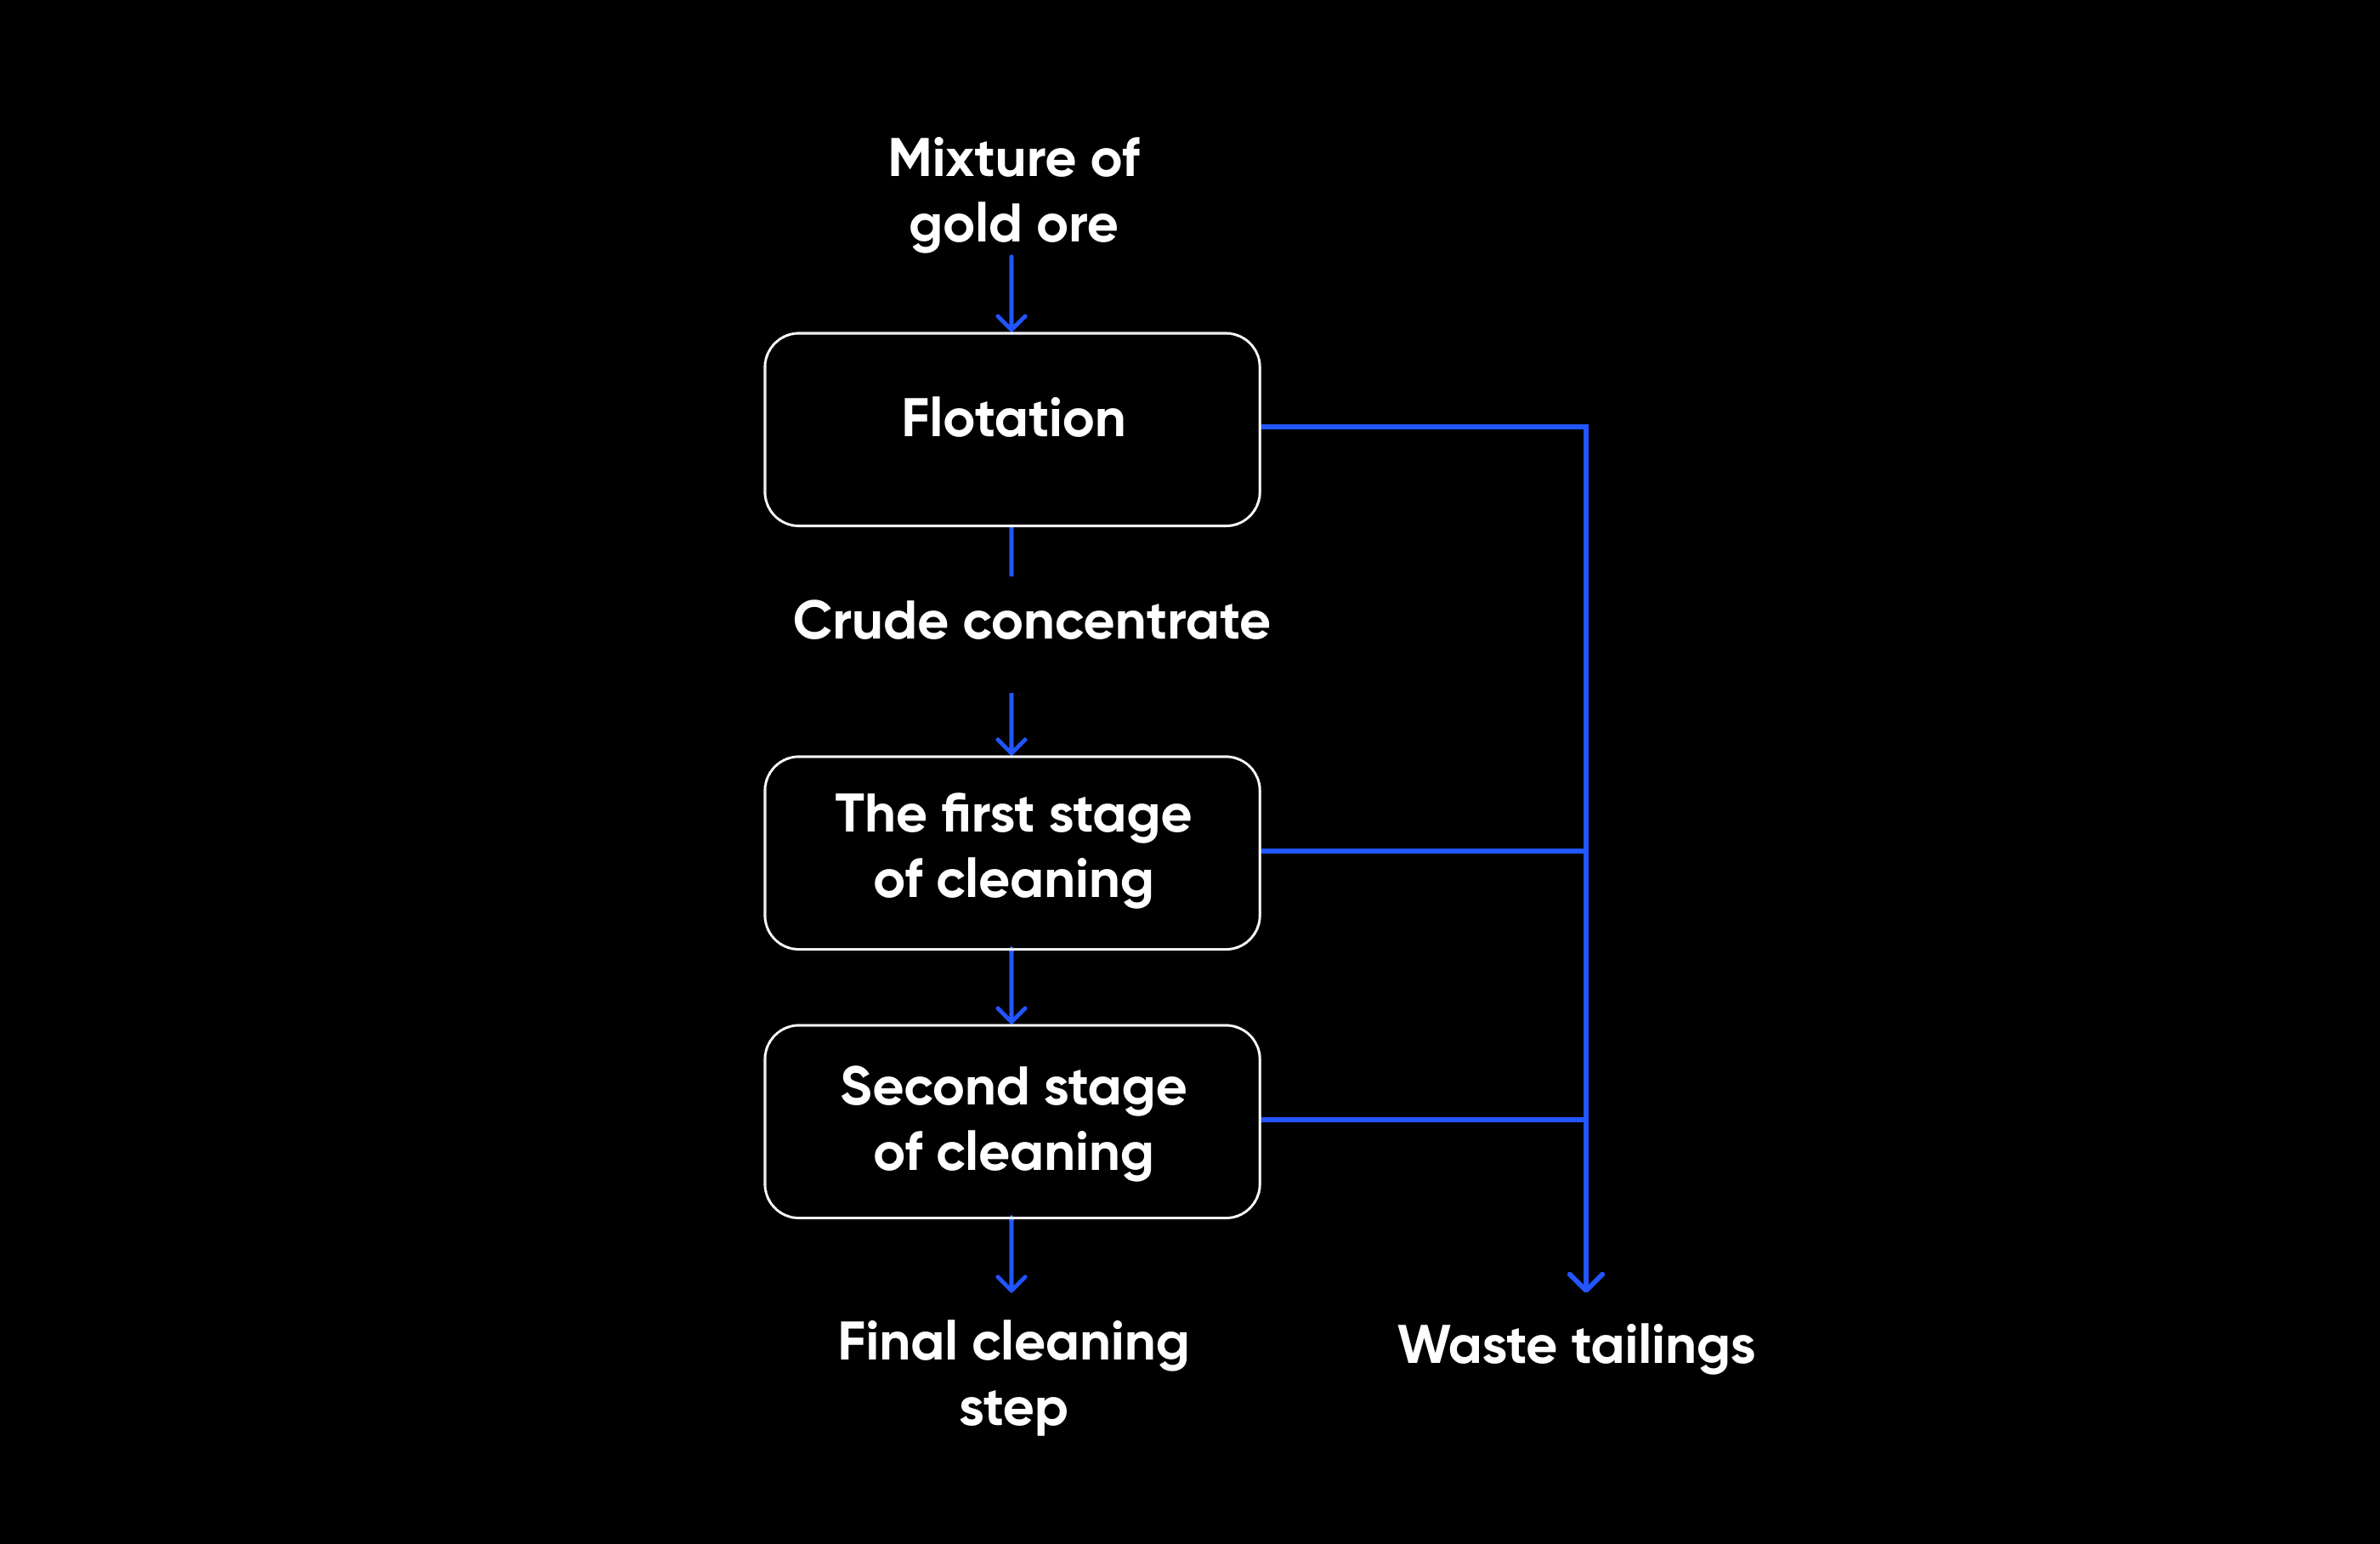
    
</div>

For Metall:au


After Flotation  First stage of cleaning  Final Specifications
count     19439.000000             19439.000000          19439.000000
mean         19.772000                32.119400             44.076513
std           3.753600                 5.627611              5.129784
min           0.000000                 0.000000              0.000000
25%          18.802523                30.463140             43.402215
50%          20.280214                32.841295             45.011244
75%          21.717843                35.048006             46.275313
max          28.824507                45.933934             52.756638

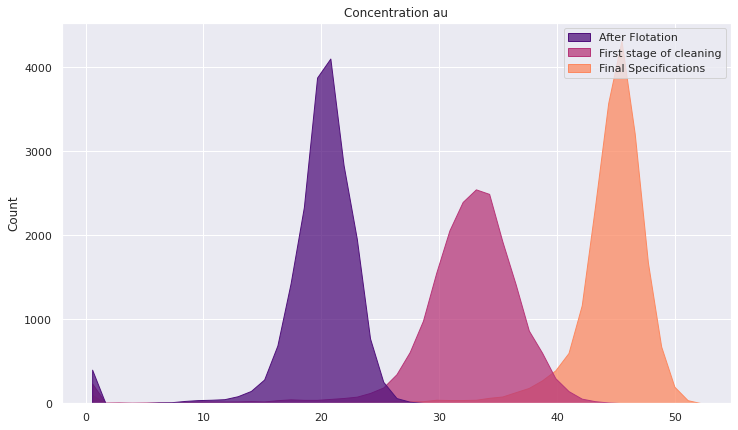

For Metall:ag


After Flotation  First stage of cleaning  Final Specifications
count     19439.000000             19439.000000          19439.000000
mean         11.994759                 8.442408              5.168387
std           2.733862                 2.054465              1.372362
min           0.000000                 0.000000              0.000000
25%          10.628337                 7.263288              4.251000
50%          12.098115                 8.507298              5.066039
75%          13.736996                 9.809001              5.895401
max          24.480271                16.081632             16.001945

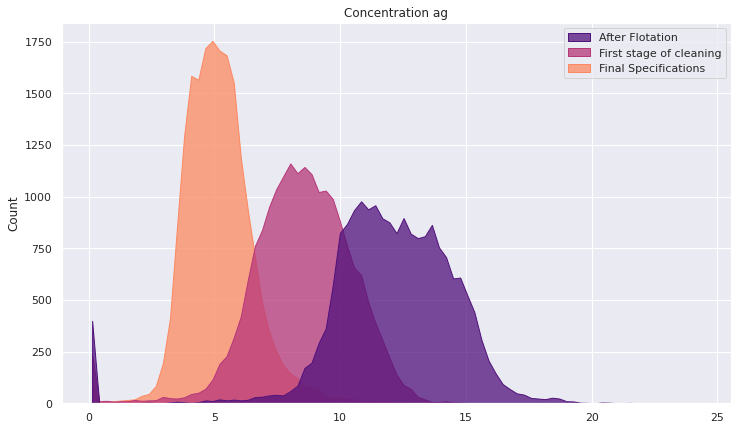

For Metall:pb


After Flotation  First stage of cleaning  Final Specifications
count     19439.000000             19439.000000          19439.000000
mean          7.606272                 9.810317              9.978821
std           1.796757                 2.572253              1.669228
min           0.000000                 0.000000              0.000000
25%           6.725987                 8.676500              9.137225
50%           7.742580                10.142270             10.102264
75%           8.565199                11.416298             11.035644
max          13.617072                17.081278             17.031899

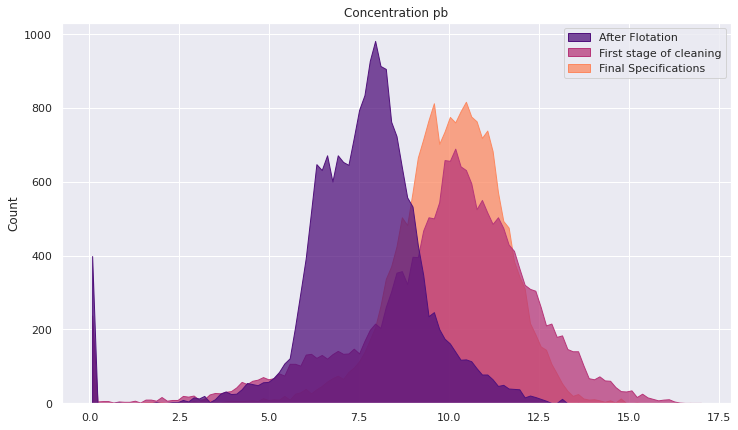

In [10]:
metal_conc = pd.DataFrame()
first = 'rougher.input.feed_'
second = 'rougher.output.concentrate_'
third = 'primary_cleaner.output.concentrate_'
fourth = 'final.output.concentrate_'


metal_list = ['au','ag','pb']

for metal in metal_list:
    metal_conc['After Flotation'] = df_full[second+metal]
    metal_conc['First stage of cleaning'] = df_full[third+metal]
    metal_conc['Final Specifications'] = df_full[fourth+metal]
    print(f'For Metall:{metal}')
    display(metal_conc.describe())
    try: 
        sns.histplot(metal_conc, element='poly',palette='magma')
        plt.title(f'Concentration {metal}')
        plt.show()
    except: print(f'Failed to build a graph for:{metal}\n')
    

<div style='border-radius: 15px; box-shadow: 2px 2px 2px; border: 1px solid green; padding: 20px'>

<b>Gold:</b>
- The concentration increases with each next technological stage. After flotation tailings are noticeable.
    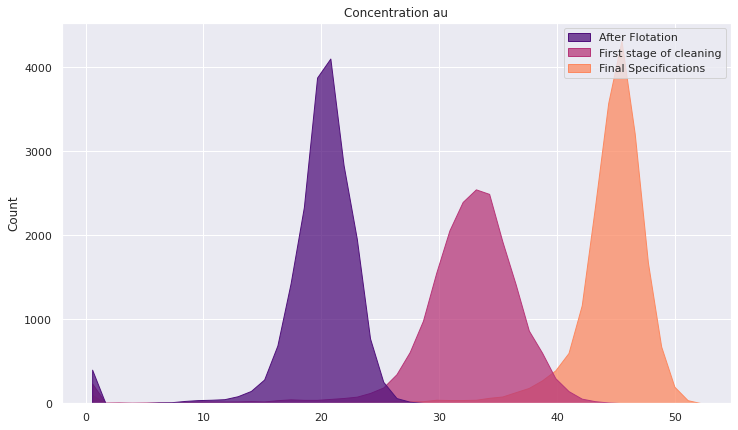
    <hr>

<b>Silver:</b>
- The concentration decreases with each subsequent technological stage. After flotation tailings are noticeable.
    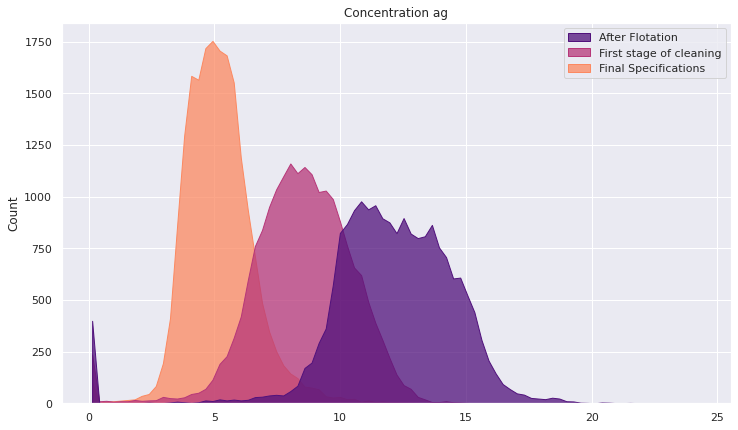
    <hr>

<b>Lead:</b>
- The concentration after Flotation increased, then the average value by the final stage of purification became less scattered and approached the average. After flotation tailings are noticeable.
    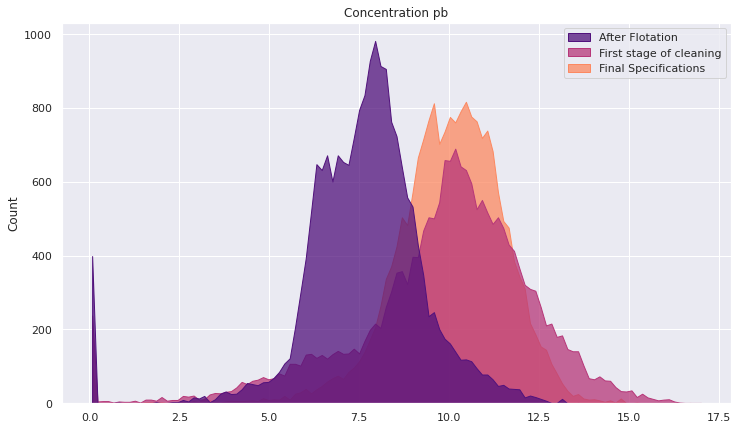
    
</div>

<div style="border-radius: 15px; box-shadow: 2px 2px 2px; border: 1px solid green; padding: 20px">

Let us compare the size distributions of raw material granules on the training and test samples. If the distributions are very different from each other, the estimation of the model will be incorrect.
    
    
</div>

Text(0.5, 0, '')

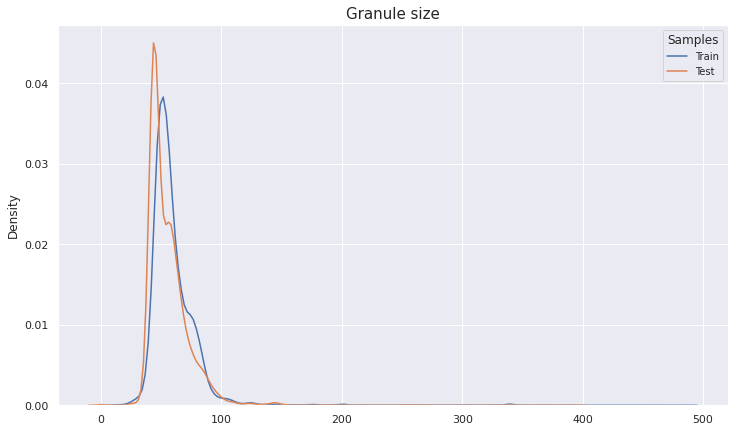

In [11]:
for frame,name in zip([df_train,df_test],
                       ['Train','Test']):
    subset = frame['rougher.input.feed_size']

    sns.distplot(subset, hist = False, kde = True,
                 label = name)
plt.figsize = (14,20)
plt.legend(prop={'size': 10}, title = 'Samples')
plt.title('Granule size', fontsize=15)
plt.xlabel(None)

<div style='border-radius: 15px; box-shadow: 2px 2px 2px; border: 1px solid green; padding: 20px'>

<b>Distributions are similar. </b>
    
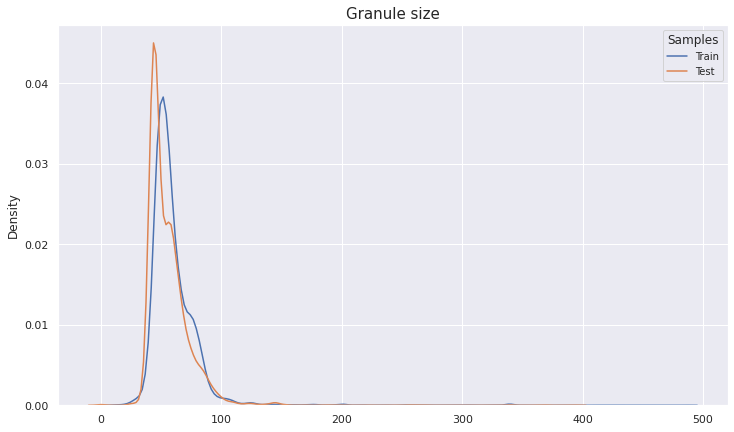
    
They do not match perfectly, but it is clear that they came from the same distribution, they have peaks in approximately the same place, and the variances are also similar. All these minor differences are caused by the finiteness of the samples and all sorts of accidents/anomalies. If we had much more data, then they could completely match.
    
    
</div>

<div style='border-radius: 15px; box-shadow: 2px 2px 2px; border: 1px solid green; padding: 20px'>

We investigate the total concentration of all substances at different stages:
    
- In raw materials (before flotation) - <code>rougher.input.concentrate</code>;
- In rougher (after flotation) - <code>rougher.output.concentrate</code>;
- Final concentrates - <code>final.output.concentrate</code>.
    
</div>

In [12]:
sum_conc = pd.DataFrame()
metal_list = ['au','ag','pb','sol']
sum_conc['before flotation'] = df_full[[first+metal_list[0], first+metal_list[1], 
                                   first+metal_list[2], first+metal_list[3]]].sum(axis=1)

sum_conc['after flotation'] = df_full[[second+metal_list[0], second+metal_list[1], 
                                      second+metal_list[2], second+metal_list[3]]].sum(axis=1)

sum_conc['final concentrate'] = df_full[[fourth+metal_list[0], fourth+metal_list[1], 
                                              fourth+metal_list[2], fourth+metal_list[3]]].sum(axis=1)
sum_conc.describe()

before flotation  after flotation  final concentrate
count      19439.000000     19439.000000       19439.000000
mean          57.320789        68.170865          68.653624
std            7.212680        12.491279           7.427536
min            0.040000         0.000000           0.000000
25%           53.557679        66.012495          67.932362
50%           57.594391        70.181495          69.598444
75%           61.953459        74.356904          71.368472
max           76.978947        88.140119          80.210644

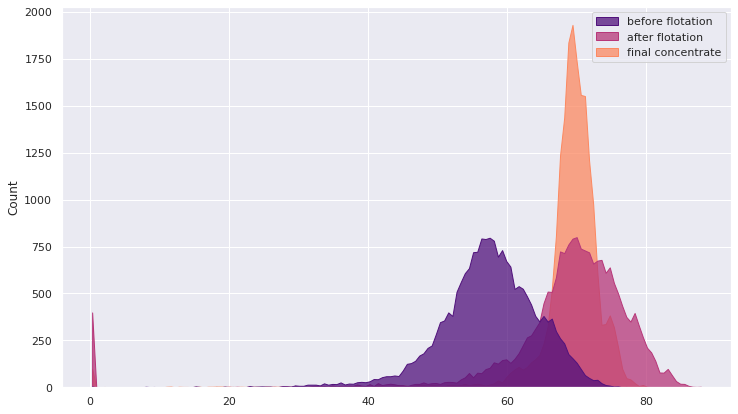

In [13]:
try: sns.histplot(sum_conc, element='poly',palette='magma')
except: print(f'Failed to plot graph\n')

<div style='border-radius: 15px; box-shadow: 2px 2px 2px; border: 1px solid green; padding: 20px'>

As seen from the histogram, we have anomalies in the total concentrations. They cannot be zero. Let's find these lines and delete them from the dataset.
    
    
</div>

In [14]:
drop_index_list = []
for i in range(len(sum_conc)):
    for column in sum_conc:
        if sum_conc[column][i] == 0:
            drop_index_list.append(sum_conc[column].index[i])
drop_index_list

# drop rows with zero sums
display(df_full.shape)

for i in drop_index_list:
    try:
        df_full = df_full.drop(index = i, axis = 1)
    except: pass
    
display(df_full.shape)

(19439, 86)

(18949, 86)

<div style='border-radius: 15px; box-shadow: 2px 2px 2px; border: 1px solid green; padding: 20px'>

Let's rebuild the histogram, now without anomalies
   
    
    
</div>

In [15]:
sum_conc1 = pd.DataFrame()

sum_conc1['Before flotation'] = df_full[[first+metal_list[0], first+metal_list[1], 
                                   first+metal_list[2], first+metal_list[3]]].sum(axis=1)

sum_conc1['After flotation'] = df_full[[second+metal_list[0], second+metal_list[1], 
                                      second+metal_list[2], second+metal_list[3]]].sum(axis=1)

sum_conc1['Final concentrate'] = df_full[[fourth+metal_list[0], fourth+metal_list[1], 
                                              fourth+metal_list[2], fourth+metal_list[3]]].sum(axis=1)
sum_conc1.describe()

Before flotation  After flotation  Final concentrate
count      18949.000000     18949.000000       18949.000000
mean          57.328171        69.571825          69.000211
std            7.175150         7.790890           5.573298
min            0.040000         0.040000           0.040000
25%           53.536062        66.321789          67.943518
50%           57.600162        70.324088          69.600838
75%           61.969195        74.446687          71.373371
max           76.978947        88.140119          80.210644

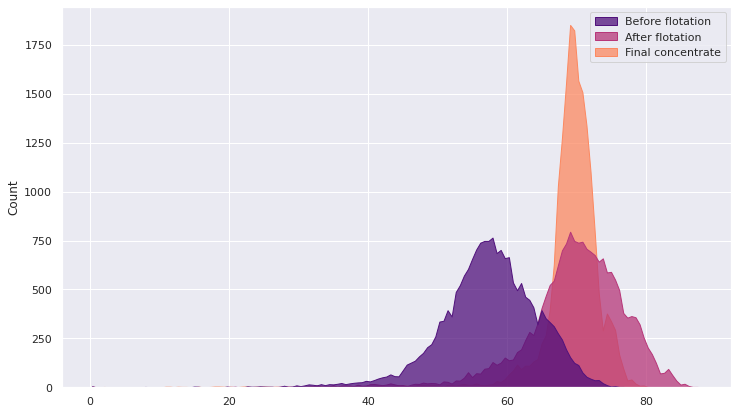

In [16]:
try: sns.histplot(sum_conc1, element='poly',palette='magma')
except: print(f'Failed to plot graph\n')

<div style='border-radius: 15px; box-shadow: 2px 2px 2px; border: 1px solid green; padding: 20px'>
    
The total concentration of all substances in the final concentrate has a minimum spread of values compared to the stages before and after flotation.
    
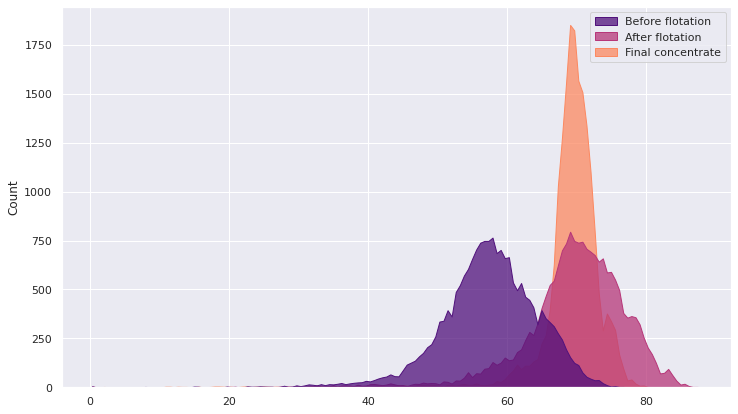
</div>

<div style='border-radius: 15px; box-shadow: 2px 2px 2px; border: 1px solid green; padding: 20px'>
    
### Intermediate conclusion
As seen from the analysis and graphs, the data correspond to the theoretical justification for the purification process of the gold ore mixture.
    
Indeed, the data show different concentrations of substances at various stages of gold ore refining, during which tailings appear. The deeper the cleaning is, the more noticeable the differences in the concentration of metals and sulfite.
    
The amount of data and types of graphs give good reason to believe that all these processes fall under the law of normal distribution.
    
The purer the concentrate becomes, the closer the content of substances in it approaches the average value, and the spread of values becomes smaller.
    
Given that the size of the granules is approximately the same everywhere, then in theory, the concentrate should eventually come close to the average value and have a spread proportional to the size of the granules. This is exactly what we see on the charts.
<hr>

After preprocessing and analyzing the data, we will start building the model. We face regression because the target features cannot be described categorically. For this, you need the following:
- Introduce a new quality metric - sMAPE (Symmetric Mean Absolute Percentage Error). Based on it, we will determine the best model;
- Divide our training set into features and target features, scale the features, and determine the best learning model by the sMAPE metric;
- Check the selected model on the test set and compare it with the constant prediction.
</div>

## Model


<div style='border-radius: 15px; box-shadow: 2px 2px 2px; border: 1px solid green; padding: 20px'>

Let's write a function to calculate the final sMAPE
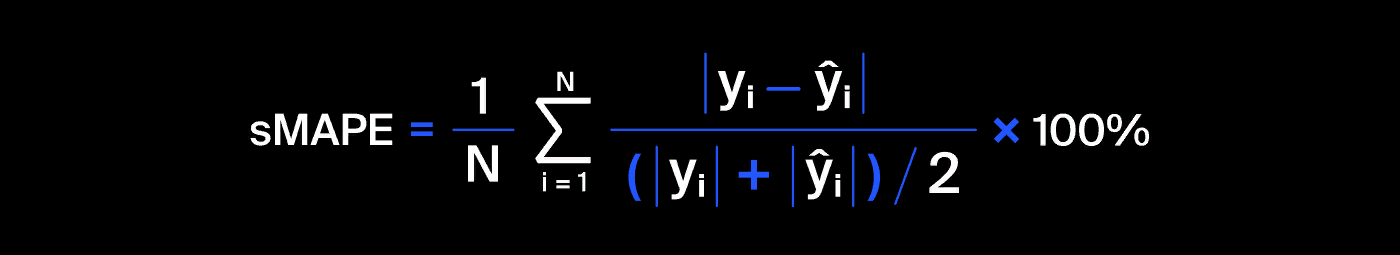

- $y_i$ is the value of the target feature for the object with serial number i in the sample on which the quality is measured;
- $\hat{y_i}$ — prediction value for the object with index i, for example, in the test set;
- N is the number of objects in the sample;
- $\sum_{i=1}^{N}$ - summation over all sample objects (i varies from 1 to N).
    
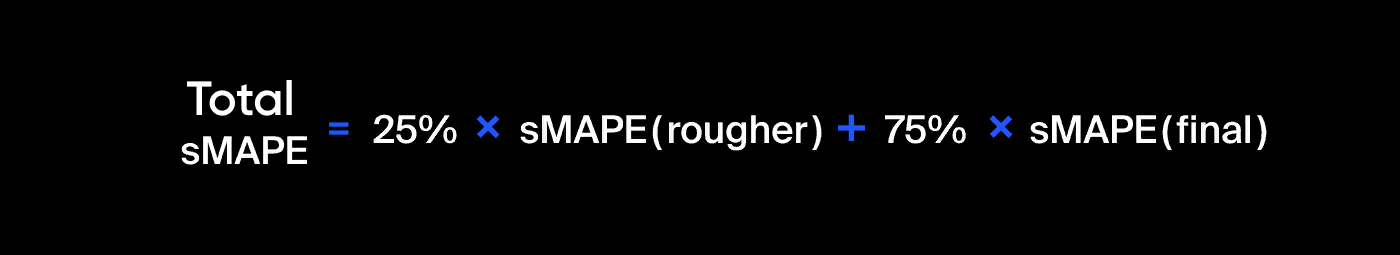
    
</div>

In [17]:
def sMAPE(target, predict):

    abs_odd = abs(predict-target)
    half_sum_abs = (abs(predict) + abs(target))*0.5
    frac = (abs_odd/half_sum_abs).sum()
    result = (100 * frac) /len(target)
    return result
    


def final_sMAPE(sMAPE_rougher, sMAPE_final):
    result = 0.25*sMAPE_rougher + 0.75*sMAPE_final
    return result

score = make_scorer(sMAPE, greater_is_better=True)

<div style='border-radius: 15px; box-shadow: 2px 2px 2px; border: 1px solid green; padding: 20px'>

Before us is the Regression task; we will train different models and evaluate their quality by cross-validation. Let's choose the best model and check it on the test set.
    
Our model should predict the following:
- <code>rougher.output.recovery</code> - rough concentrate recovery efficiency;
- <code>final.output.recovery</code> - final concentrate recovery efficiency.
    
The first target feature is only affected by the features that appear in the data during the rougher stage - Flotation.
    
The second target feature is affected by all features.
    
</div>



<div style='border-radius: 15px; box-shadow: 2px 2px 2px; border: 1px solid green; padding: 20px'>

Let's write a function that will select features for our models to predict different target features.
Based on the provided theory for the recovery of rough concentrates:
- To find the target value of <code>rougher.output.recovery</code>, we need to examine only those features that relate to the Flotation stage;
- To find the target value of <code>final.output.recovery</code>, we need to examine features that apply to all stages after Flotation;
- For the best performance of Regressions, we will scale all features;
- The values of the target features for the training and test samples will be taken from the entire dataset according to their indices.
    
</div>

In [18]:
# Selections for roughter and final
def features_n_target_selector_n_scaler(df_features, df_targets):

    rougher_columns = list(filter(lambda x: 'rougher' in x, df_features.columns.tolist()))
    final_columns = list(set(df_features.columns)-set(rougher_columns))


    rougher_features=df_features.loc[df_features.index.intersection(df_full.index), rougher_columns]
    final_features=df_features.loc[df_features.index.intersection(df_full.index), final_columns]
    
    scaler = StandardScaler()
    scaler.fit(rougher_features)
    rougher_features = scaler.transform(rougher_features)
    scaler.fit(final_features)
    final_features = scaler.transform(final_features)

    rougher_target = df_full.loc[df_targets.index.intersection(df_full.index), 'rougher.output.recovery']
    final_target = df_full.loc[df_targets.index.intersection(df_full.index), 'final.output.recovery']

    return rougher_features,final_features,rougher_target,final_target

<div style='border-radius: 15px; box-shadow: 2px 2px 2px; border: 1px solid green; padding: 20px'>

We leave only those features in the training sample that are found in the test sample. Next, we use the function above and select the scaled features and target features from the training sample
    
</div>

In [19]:
# We leave only those features in the training sample that are found in the test
train_features = df_train.drop(missing, axis=1)


In [20]:
# Select the scaled features and target features from the training dataset
train_rougher_features,train_final_features,\
train_rougher_target,train_final_target = features_n_target_selector_n_scaler(train_features, df_train)

<div style='border-radius: 15px; box-shadow: 2px 2px 2px; border: 1px solid green; padding: 20px'>

Our model should predict better than the constant model. To calculate the final sMAPE, we take the average value for the target feature of the training sample.
    
</div>

In [21]:
# Mean prediction

mean_train_rougher_target = pd.Series(train_rougher_target.mean(), index=train_rougher_target.index)
mean_train_final_target = pd.Series(train_final_target.mean(), index=train_final_target.index)

mean_smape_train_rougher = sMAPE(train_rougher_target,mean_train_rougher_target)
mean_smape_train_final = sMAPE(train_final_target,mean_train_final_target)
mean_final_smape = final_sMAPE(mean_smape_train_rougher,mean_smape_train_final)

print(f'The model should predict the sMAPE of the washing efficiency after flotation better than \
{round(mean_smape_train_rougher,2)}%',
      f'\nThe model should predict the final concentrate recovery efficiency sMAPE better than {round(mean_smape_train_final,2)}%',
      f'\nThe final sMAPE should be better than {round(mean_final_smape,2)}%')

The model should predict the sMAPE of the washing efficiency after flotation better than 7.35% 
The model should predict the final concentrate recovery efficiency sMAPE better than 10.23% 
The final sMAPE should be better than 9.51%


<div style='border-radius: 15px; box-shadow: 2px 2px 2px; border: 1px solid green; padding: 20px'>

Let's write a function to train our models and evaluate their quality using cross-validation. Let's take five blocks for cross-validation, take <code>score =make_scorer(sMAPE,greater_is_better=True)</code> as a counter and return the average sMAPE values for each step <code>rougher</code> and <code> final</code> and last metric <code>finalsMAPE</code>
    
</div>

In [22]:
def model_train(model):

    result_rougher=cross_val_score(model, train_rougher_features, train_rougher_target, scoring=score, cv=5)
    result_final = cross_val_score(model, train_final_features, train_final_target, scoring=score, cv=5)

    mean_result_rougher = result_rougher.mean()
    mean_result_final = result_final.mean()
    result = final_sMAPE(mean_result_rougher,mean_result_final)
    
    return mean_result_rougher,mean_result_final, result

<div style='border-radius: 15px; box-shadow: 2px 2px 2px; border: 1px solid green; padding: 20px'>
Linear Regression.
</div>

In [23]:
rougher_table =[]
final_table =[]
result_table = []

LR=LinearRegression()

lr_result_rougher,lr_result_final, lr_result = model_train(LR)
rougher_table.append(lr_result_rougher)
final_table.append(lr_result_final)
result_table.append(lr_result)

lr_table = pd.DataFrame(data = (rougher_table, final_table, result_table)).T
lr_table.columns = ('sMAPE before flotetion', 'sMAPE after final cleaning', 'Final sMAPE')
display(lr_table)

sMAPE before flotetion  sMAPE after final cleaning  Final sMAPE
0                6.660436                     9.86844     9.066439

<div style='border-radius: 15px; box-shadow: 2px 2px 2px; border: 1px solid green; padding: 20px'>
Ridge Regression.
</div>

In [24]:
rougher_table =[]
final_table =[]
result_table = []
best_alpha = []

for alpha in tqdm(np.arange(0.66, 3.01, 0.14),colour = 'black'):
    ridge=Ridge(random_state=12345, alpha = alpha)
    ridge_result_rougher,ridge_result_final, ridge_result = model_train(ridge)
    
    rougher_table.append(ridge_result_rougher)
    final_table.append(ridge_result_final)
    result_table.append(ridge_result)
    best_alpha.append(alpha)
    
ridge_table = pd.DataFrame(data = (best_alpha, rougher_table, final_table, result_table)).T
ridge_table.columns = ('Alfa','sMAPE before flotation', 'sMAPE after final cleaning', 'Final sMAPE')
display(ridge_table.sort_values(by = 'Final sMAPE', ascending = True).head(5))

  0%|          | 0/17 [00:00<?, ?it/s]

Alfa  sMAPE before flotation  sMAPE after final cleaning  Final sMAPE
16  2.90                6.651710                    9.864519     9.061317
15  2.76                6.652103                    9.864707     9.061556
14  2.62                6.652498                    9.864895     9.061796
13  2.48                6.652895                    9.865083     9.062036
12  2.34                6.653296                    9.865271     9.062277

<div style='border-radius: 15px; box-shadow: 2px 2px 2px; border: 1px solid green; padding: 20px'>
Lasso Regression.
</div>

In [25]:
rougher_table =[]
final_table =[]
result_table = []
best_alpha = []

for alpha in tqdm(np.arange(0.1, 2.21, 0.14),colour = 'black'):
    lasso=Lasso(random_state=12345, alpha = alpha)
    lasso_result_rougher,lasso_result_final, lasso_result = model_train(lasso)
    
    rougher_table.append(lasso_result_rougher)
    final_table.append(lasso_result_final)
    result_table.append(lasso_result)
    best_alpha.append(alpha)
    
lasso_table = pd.DataFrame(data = (best_alpha, rougher_table, final_table, result_table)).T
lasso_table.columns = ('Alfa','sMAPE before flotation', 'sMAPE after final cleaning', 'Final sMAPE')
display(lasso_table.sort_values(by = 'Final sMAPE', ascending = True).head(5))

  0%|          | 0/16 [00:00<?, ?it/s]

Alfa  sMAPE before flotation  sMAPE after final cleaning  Final sMAPE
0  0.10                6.292830                    9.703437     8.850785
4  0.66                6.399447                    9.689158     8.866730
3  0.52                6.328287                    9.726091     8.876640
5  0.80                6.476982                    9.685302     8.883222
2  0.38                6.290720                    9.775745     8.904489

<div style='border-radius: 15px; box-shadow: 2px 2px 2px; border: 1px solid green; padding: 20px'>
We've got the following values: <br> <br> 

    
|Regression|sMAPE before flotation|sMAPE of final concentrate|final sMAPE|
|--------:|:---------------:|:--------------------------:|:------------:|
|Constant|7.35%            |10.23%                      |9.51%         |
|Linear |6.66%            |9.87%                       |9.06%         |
|Ridge     |6.65%            |9.87%                       |11.19%        |
|<b><font color='red'>Lasso    |<b><font color='red'>6.29%|<b><font color='red'>9.7%|<b><font color='red'>8.85%|   
  
<hr> 
    
- Regression models train relatively poorly on features before Float. Predictions could be better if more features were fed to the model;
- To predict the efficiency of recovery of the final concentrate, the models have enough features, and they predict better than the constant mean;
- The final sMAPE of all our models is better than that of a constant;
- Lasso regression works best. We will use it on the test sample.
</div>

<div style='border-radius: 15px; box-shadow: 2px 2px 2px; border: 1px solid green; padding: 20px'>
    
### The final stage
</div>

In [26]:
# We select the scaled features from the test dataset and find the corresponding target features in the full dataset 
test_rougher_features,test_final_features,\
test_rougher_target,test_final_target = features_n_target_selector_n_scaler(df_test, df_test)

<div style='border-radius: 15px; box-shadow: 2px 2px 2px; border: 1px solid green; padding: 20px'>

Let's take the DummyRegressor model with the median strategy as a constant. We will train it on the training set and predict the predictions for the test. Our model should predict better than the constant model.
    
</div>

In [27]:
def final_test(model_rougher, model_final):

    model_rougher.fit(train_rougher_features,train_rougher_target)
    model_final.fit(train_final_features,train_final_target)

    rougher_pred = model_rougher.predict(test_rougher_features)
    final_pred = model_final.predict(test_final_features)

    smape_rougher = sMAPE(test_rougher_target,rougher_pred)
    smape_final = sMAPE(test_final_target,final_pred)
    final_smape = final_sMAPE(smape_rougher,smape_final)

    print(f'sMAPE post-flotation cleaning efficiency {round(smape_rougher,2)}%',
      f'\nsMAPE final concentrate recovery efficiency {round(smape_final,2)}%',
      f'\nFinal sMAPE {round(final_smape,2)}%')
    return rougher_pred, final_pred

print('DummyRegressor')

dummy_rougher_pred, dummy_final_pred = final_test(DummyRegressor(strategy='mean'), 
                                                  DummyRegressor(strategy='mean'))

DummyRegressor
sMAPE post-flotation cleaning efficiency 5.38% 
sMAPE final concentrate recovery efficiency 8.56% 
Final sMAPE 7.77%


<div style='border-radius: 15px; box-shadow: 2px 2px 2px; border: 1px solid green; padding: 20px'>
Lasso regression. Let's train the model on the training set and predict the values for the test set. If the final sMape is better than the constant model, that you have successfully learned to predict the efficiency of the recovery of rough and fan concentrates
</div>

In [28]:
print('Lasso')
lasso_rougher_pred, lasso_final_pred = final_test(Lasso(random_state=12345, alpha = 1.08),
                                                    Lasso(random_state=12345, alpha = 1.08))


Lasso
sMAPE post-flotation cleaning efficiency 4.76% 
sMAPE final concentrate recovery efficiency 8.05% 
Final sMAPE 7.23%


<div style='border-radius: 15px; box-shadow: 2px 2px 2px; border: 1px solid green; padding: 20px'>
We've got the following values:
    
|Model|sMAPE defore flotation|sMAPE of final concentrate|Final sMAPE|
|--------:|:---------------:|:--------------------------:|:------------:|
|Constant|5.38%            |8.56%                       |7.77%         |
|<b><font color='green'>Final model|<b><font color='green'>4.76%|<b><font color='green'>8.05%|<b><font color='green'>7.23%|
    
</div>

Recovery efficiency after flotation


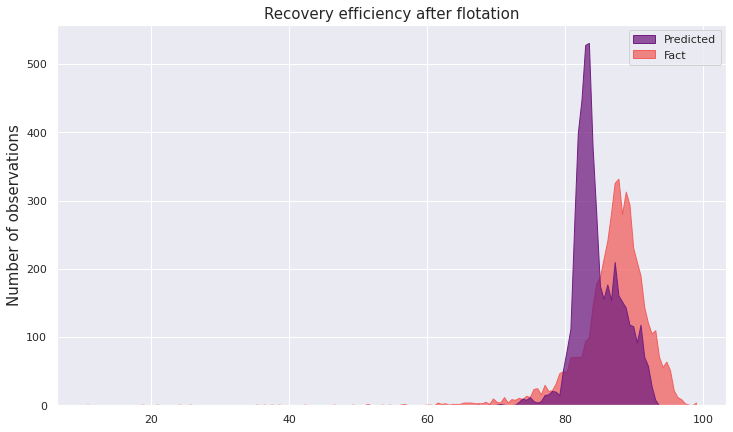

Recovery efficiency of final concentrate


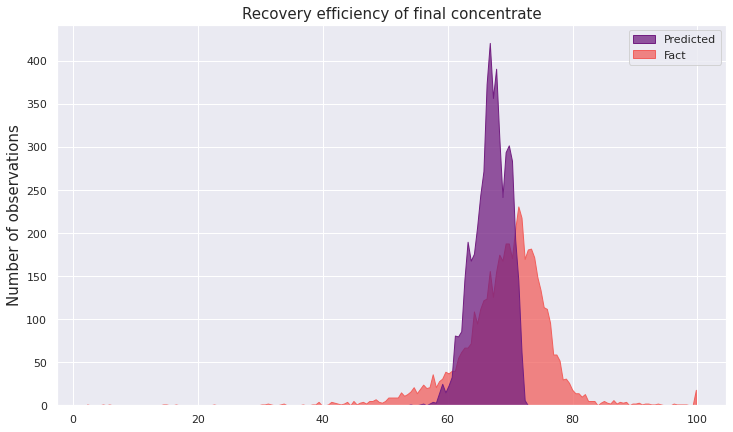

In [29]:
target_predict = pd.DataFrame()
predictions = [lasso_rougher_pred,lasso_final_pred]
targets = [test_rougher_target,test_final_target]
final_stage = ['after flotation', 'of final concentrate']

for pred, target, stage in zip(predictions,targets,final_stage):
    
    target_predict['Predicted'] = pred
    target_predict['Fact'] = target.reset_index(drop = True)

    print(f'Recovery efficiency {stage}')
    try:
        sns.histplot(target_predict, element='poly',palette='magma')
        plt.title('Recovery efficiency ' + stage, fontsize=15)
        plt.ylabel('Number of observations', fontsize=15)
        plt.show()
    except: print(f'Failed to build a graph for recovery efficiency {stage}\n')

<div style='border-radius: 15px; box-shadow: 2px 2px 2px; border: 1px solid green; padding: 20px'>

### Conclusion
    
At the data preprocessing stage, we were provided information on the parameters for converting a mixture of gold ore into the final concentrate, measured every hour. The technological process is quite tricky, so various features were included in the data.

All information was divided into three samples: Complete, Training, and Test.
After preprocessing and data analysis, they were studied and cleared of gaps.
A quality metric was developed at the model preparation stage - sMAPE (Symmetric Mean Absolute Percentage Error). According to it, we determined the best model among the trained ones, comparing the results of the constant model with the trained regressors.

<hr>
    
The Lasso Regression with coefficient alpha = 1.08 was chosen as the prototype of the machine learning model. Our model received the following sMAPE values:
    
    
|Model|sMAPE model before flotation|sMAPE final concentrate|Final sMAPE|
|---------------:|:-------:|:------------- -------------:|:------------:|
|Lasso Regression |4.76% |8.05% |7.23% |

As can be seen, our model deviates from the correct prediction of recovery efficiency by 9.75% on average. Therefore, the actual value will be 10% of the predicted value.

The graph of the Efficiency of Cleaning after Flotation shows that the model predicts values close to the calculated ones and has the same distribution.
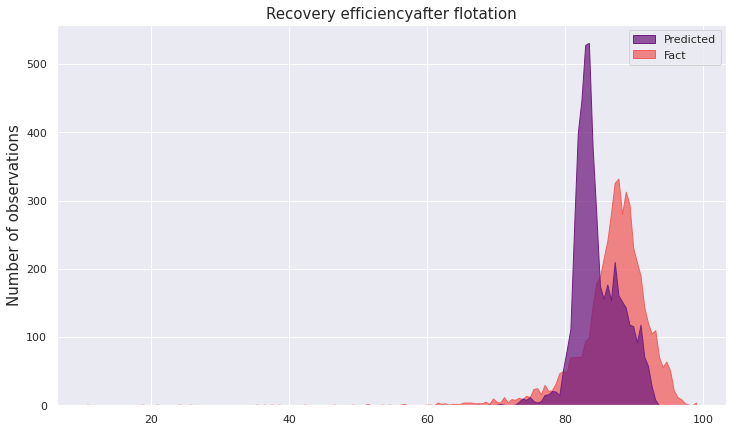
    
The final concentrate recovery efficiency graph shows that the model predicts values close to the calculated ones and has the same distribution.

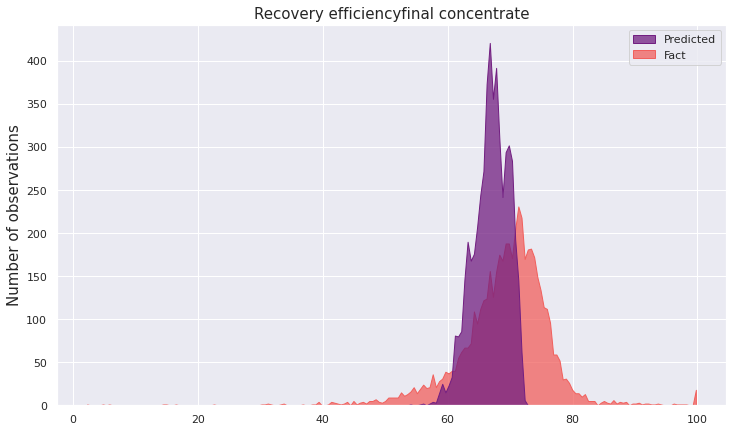
    
It is difficult for models to predict the values of the target feature since it tends to the mean value and has a normal distribution.
    
<hr>
    
The model could have predicted values close to zero. We should collect more data on such non-standard deviations from the normal distribution to improve the model's performance.
If you provide more features where the efficiency value is further away from the mean, the model will be better able to predict them.
    
<hr>

To improve the result, we can also collect additional observations. For example, they can be:
- Temperature indicator. After all, in the process of flotation, physical and chemical processes occur, and the temperature of the solution can certainly change;
- Density. In addition to the concentration and amount of a substance, you can use the indicators of a hydrometer. Since after the use of various reagents, depending on the quality of the reaction, there may be a different amount of tailings;
- Data on the height of the layer of foam with sulfides to evaluate its yield and the performance of the skimmer;
- Data on compressed air pressure during flotation.
</div>